In [1]:
import os
from functools import partial 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from scipy.stats import spearmanr
from matplotlib_venn import venn3


In [30]:
def plot_spearman(data, name_out='fig-spearman.png'):
    times = np.arange(0,1050,50)
    for i, timeseries in enumerate(data):
        sprmn = [spearmanr(timeseries[:,i], timeseries[:,-1])[0] for i in range(timeseries.shape[-1]) ]
        # define colors and names
        if i == 0:
            c = 'firebrick'
            l = 'whole protein'
        if i == 1:
            c = 'mediumvioletred'
            l = '8Å surrounding'
        if i == 2:
            c='tab:blue'
            l = 'residue'
        plt.plot(times, sprmn, color=c, label=l)
        plt.scatter(times, sprmn, color=c, s=10)
    plt.yscale('function', functions=(partial(np.power, 10.0), np.log10))
    plt.grid(True, which="major", alpha=0.6)
    plt.xticks(list(plt.xticks()[0]) + [50])
    plt.xlabel('time (ps)')
    plt.ylabel('Spearman ρ with 1ns')
    plt.xlim(0,1000)
    plt.ylim(0,1.01)
    plt.legend()
    plt.savefig(name_out, dpi=300, bbox_inches='tight')
    plt.show()

def plot_3dhist(data, highlight=[],name_out='fig-3dhist.png'):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection='3d')

    #generate consistent bins
    a, b = np.histogram(data['1000'].values, bins=30)
    count = 0
    for time in data.columns:
        count+=1
        c = count/len(data.columns)
        sel = [i for i in data[time].index if  i != 'N92K']
        data_t = data.loc[sel][time].values

        a, b = np.histogram(data_t, bins=b)
        bx = (b[1:] + b[:-1]) / 2
        bw = abs(np.average(b[1:] - b[:-1]))    

        a2, b2 = np.histogram(data[time].loc[highlight], bins=b)
        bx2 = (b2[1:] + b2[:-1]) / 2
        # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
        ax.bar(bx2, a2, zs=int(time), zdir='y', color='green', alpha=1, width=bw, lw=1, ec='black')
        ax.bar(bx, a, zs=int(time), zdir='y', color=(c,0,1-c), alpha=0.8, width=bw, lw=1, ec='black')
        ax.bar(bx2, a2, zs=int(time), zdir='y', color='green', alpha=1, width=bw, lw=1, ec='black')

    ax.set_xlabel('mean BoostMut score')
    ax.set_ylabel('time (ps)')
    plt.savefig(name_out, bbox_inches='tight', dpi=300)
    plt.show()    
    
def roc_normal(in_true, in_vals):
    '''
    standard ROC curve
    '''
    in_true = np.array(in_true)
    in_vals = np.array(in_vals)
    # get total number of true positives and negatives
    total_pos = len([i for i in in_true if i == 1])
    total_neg = len([i for i in in_true if i == 0])
    # sort positives/negatives according to given values
    true_sorted = in_true[np.argsort(in_vals)[::-1]]
    #generate positions on ROC curve for each value in sorted list
    roc_list_x, roc_list_y = [0],[0]
    roc_val_x, roc_val_y = 0, 0 
    for i in true_sorted:
        if i == 1: 
            roc_val_y += 1/total_pos
        if i == 0:
            roc_val_x += 1/total_neg
        roc_list_x.append(roc_val_x)
        roc_list_y.append(roc_val_y)
    return roc_list_x, roc_list_y


def roc_tm(in_true, in_vals):
    '''
    adapted version of ROC curve that scales positives by their relative contribution
    '''
    vals_true = np.array(in_true)
    vals_true = vals_true / sum(vals_true[vals_true > 0])
    in_vals = np.array(in_vals)
    total_neg = len([i for i in vals_true if i == 0])
    true_sorted = vals_true[np.argsort(in_vals)[::-1]]
    roc_list_x, roc_list_y = [0],[0]
    roc_val_x, roc_val_y = 0, 0 
    for i in true_sorted:
        if i > 0: 
                roc_val_y += i
        else:
            roc_val_x += 1/len(vals_true[vals_true <= 0])
        roc_list_x.append(roc_val_x)
        roc_list_y.append(roc_val_y)
    return roc_list_x, roc_list_y

def plot_roc(data, scale=False, exclude=[], name_out='out-roc.png'):
    '''
    plot the ROC curves for a given dataset
    '''
    aucs = []
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(5, 5))
    boostmut_cols = [i for i in data.columns if i not in ['exp_tested', 'stabilizing', 'dtm']+exclude]
    # only take experimentally tested values
    data_exp = data[data.exp_tested]
    # the foldx values with normalized stdev are used normalization does not affect the ROC curve
    data_pred_fx = data_exp['foldx'].values
    data_pred_bm = data_exp[boostmut_cols].sum(axis=1).values
    if scale:
        data_true = [0 if np.isnan(i) else i for i in data_exp.dtm.values.astype(float)]
        x1,y1 = roc_tm(data_true, data_pred_fx)
        x2,y2 = roc_tm(data_true, data_pred_bm)
    else:
        data_true = data_exp.stabilizing.values.astype(int)
        x1,y1 = roc_normal(data_true, data_pred_fx)
        x2,y2 = roc_normal(data_true, data_pred_bm)
    plt.plot(x1,y1, label='FoldX')
    plt.plot(x2,y2, label='FoldX+BM', color='firebrick')
    aucs.append(auc(x1,y1))
    aucs.append(auc(x2,y2))  
    plt.plot(np.arange(0,1.2,0.1),np.arange(0,1.2,0.1), color='grey', alpha=0.5)
    plt.legend(loc=2)
    plt.xlim(-0.02,1)
    plt.ylim(0,1.02)
    plt.savefig(name_out, bbox_inches='tight', dpi=300)
    plt.show()
    return aucs

def plot_roc_fullrange(data, scale=False, exclude=[], 
                       predictor='foldx_raw', predictor_scaled='foldx', cutoff=0, 
                       name_out='out-roc-full.png'):
    '''
    plot the ROC curves for a given dataset where both mutations passing and not passing
    the primary predictor are included.
    '''
    aucs = []
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(5, 5))
    # get index of muts passing and not passing cutoff
    boostmut_cols = [i for i in data.columns if i not in ['foldx_raw', 'ddg']+exclude]
    index_passed = [i for i in data.index if data[predictor].loc[i] <= cutoff]
    index_notpassed = [i for i in data.index if data[predictor].loc[i] > cutoff]
    index_complete = np.append(index_passed,index_notpassed)
    # sort all values passing cutoff before all all values not passing cutoff 
    vals_fx = data.loc[index_complete][predictor_scaled].values
    vals_passed = data.loc[index_passed][boostmut_cols].sum(axis=1).values + 1000
    vals_notpassed = data.loc[index_notpassed][predictor_scaled].values - 1000
    vals_complete = np.append(vals_passed, vals_notpassed)
    
    # get true vals and location of cutoff in ROC curve
    if scale:
        data_true = [ max(0, -i) for i in data.loc[index_complete].ddg.values]
        cutoff_x = len([i for i in data_true[:len(index_passed)] if not i]) / len([i for i in data_true if not i])
        x1,y1 = roc_tm(data_true, vals_fx)
        x2,y2 = roc_tm(data_true, vals_complete)
    else:
        data_true = [ i < 0 for i in data.loc[index_complete].ddg.values] 
        cutoff_x = len([i for i in data_true[:len(index_passed)] if i == 0]) / len([i for i in data_true if i == 0])
        x1,y1 = roc_normal(data_true, vals_fx)
        x2,y2 = roc_normal(data_true, vals_complete)
    pred_names = {'foldx':'FoldX','SO':'Stability Oracle'}
    plt.plot(x1,y1, label='{}'.format(pred_names[predictor_scaled]), color='tab:blue')
    plt.plot(x2,y2, label='{}+BM'.format(pred_names[predictor_scaled]), color='firebrick')
    aucs.append(auc(x1,y1))
    aucs.append(auc(x2,y2))  
    plt.axvspan(cutoff_x, 1, color='grey', alpha=0.3, lw=0)
    plt.legend(loc='lower right')
    plt.xlim(-0.02,1)
    plt.ylim(0,1.02)
    plt.savefig(name_out, bbox_inches='tight', dpi=300)
    plt.show()     
    return aucs    
        

def plot_bars(values, species, colors, name_out='bar-out.png', headspace=0.14):
    plt.rcParams.update({'font.size': 14})
    x = np.arange(len(species))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    fig, ax = plt.subplots(layout='constrained')
    fig.set_figwidth(4)
    for attribute, measurement in values.items():
        offset = width * multiplier +0.12
        rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[attribute])
        print(measurement)
        ax.bar_label(rects, padding=5, rotation=70)
        multiplier += 1
    ax.set_ylabel('AUC')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left',)
    ax.set_ylim(0., 1+headspace)
    ax.set_xlim(-0.2, 2.7)
    plt.hlines(0.5, -0.5,3, color='red', alpha=0.5, zorder=-2, linestyle='dashed')
    plt.savefig(name_out, bbox_inches='tight', dpi=300)
    plt.show()



def plot_square_area(ax, numbers_in, x_offset=0, x_size=1, y_size=1, colors=('grey','tab:blue', 'firebrick')):
    # prepare neccesary variables
    u_c, s_c, d_c = colors
    untest, stab, destab = numbers_in
    total = untest+destab+stab
    stabrat = stab/(destab+stab)
    x_div = x_size*(untest/total)+x_offset
    y_div = y_size*stabrat
    
    # get tuple of x, y1, y2 coordinates for each area 
    untest_area = ([x_offset, x_div], [0,0], [y_size,y_size])
    stab_area = ([x_div, x_size+x_offset], [0,0], [y_div, y_div])
    destab_area = ([x_div, x_size+x_offset], [y_div, y_div], [y_size,y_size])
    
    # fill area according to color
    ax.fill_between(*untest_area, color=u_c, alpha=0.7 )
    ax.fill_between(*destab_area, color=s_c)
    ax.fill_between(*stab_area, color=d_c)

    if int(untest) != 0:
        ax.text(0.5*x_div, 0.5*y_size, str(int(untest)), horizontalalignment='center', verticalalignment='center')
    if int(destab) != 0:
        ax.text(x_div+0.5*(x_size-x_div+x_offset), y_div+0.5*(y_size-y_div), str(int(destab)), horizontalalignment='center', verticalalignment='center')
    if int(stab) != 0:
        ax.text(x_div+0.5*(x_size-x_div+x_offset), 0.5*(y_div), str(int(stab)), horizontalalignment='center', verticalalignment='center')

def plot_square(data, name_out='out-square.png'):
    boostmut_cols = [i for i in data.columns if i not in ['exp_tested', 'stabilizing', 'dtm']]
    sel_exp =  set(data[data.exp_tested].index)
    sel_boostmut = set(data[boostmut_cols].sum(axis=1).sort_values(ascending=False).index[:len(sel_exp)])
    sel_stab = set(data[data.stabilizing].index)
    
    a1, b1, c1 = len(sel_boostmut-sel_exp),  len(sel_boostmut&sel_stab), len(sel_boostmut&sel_exp-sel_stab)
    a2, b2, c2 = 0, len(sel_stab), len(sel_exp-sel_stab)
    
    fig, ax = plt.subplots()
    fig.set_figheight(3)
    plot_square_area(ax, (a1, b1, c1))
    plot_square_area(ax, (a2, b2, c2), x_offset=1.2)
    ax.axis('off')
    plt.savefig(name_out, bbox_inches='tight', dpi=300)
    plt.show()

In [6]:
# load in data for long LEH runs
data_leh_long_p = pd.read_csv('./data/leh_data_long_protein.csv',index_col=0)
data_leh_long_s = pd.read_csv('./data/leh_data_long_surrounding.csv',index_col=0)
data_leh_long_r = pd.read_csv('./data/leh_data_long_residue.csv',index_col=0)
data_leh_long_total = pd.read_csv('./data/leh_data_long_total.csv',index_col=0)

# load in data for FRESCO proteins
leh_data = pd.read_csv('./data/leh_data.csv', index_col=0)
adh_data = pd.read_csv('./data/adh_data.csv', index_col=0)
hmfo_data = pd.read_csv('./data/hmfo_data.csv', index_col=0)

# load in data for proteins from T2837 set
t1bz6_data = pd.read_csv('./data/t1bz6_data.csv', index_col=0)
t1lz1_data = pd.read_csv('./data/t1lz1_data.csv', index_col=0)
t2lzm_data = pd.read_csv('./data/t2lzm_data.csv', index_col=0)

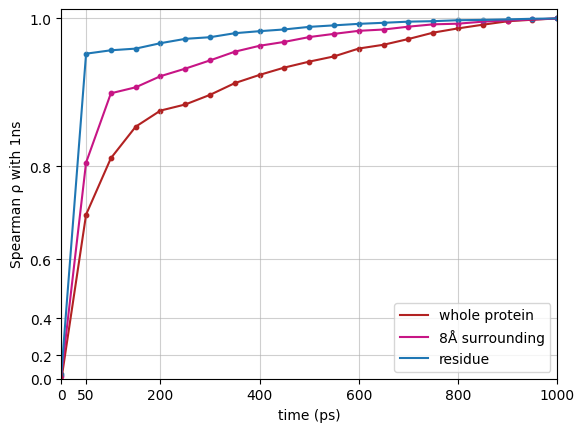

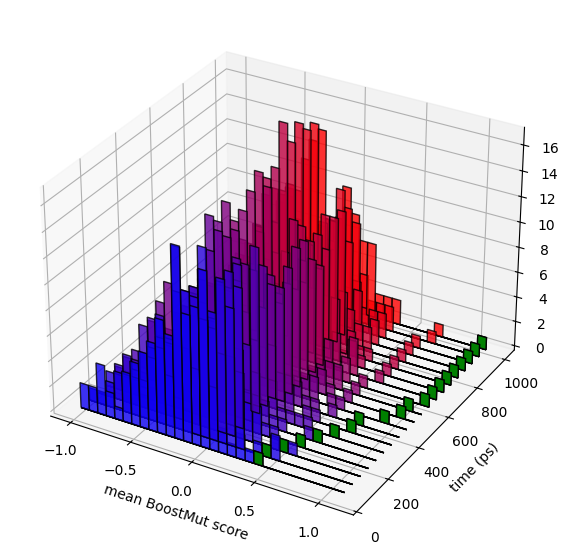

In [7]:
# figure 2: plot spearman and 3d histogram for long LEH data

plot_spearman([data_leh_long_p.values, data_leh_long_s.values, data_leh_long_r.values],
               name_out='./figures/fig_2_leh_long_spearman.png')
plot_3dhist(data_leh_long_total, highlight=['N92K'], name_out='./figures/fig_2-leh_long_3dhist.png')


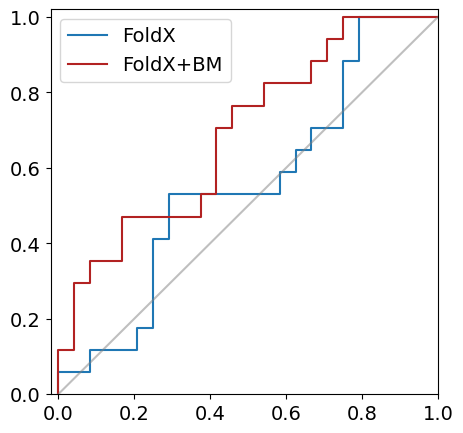

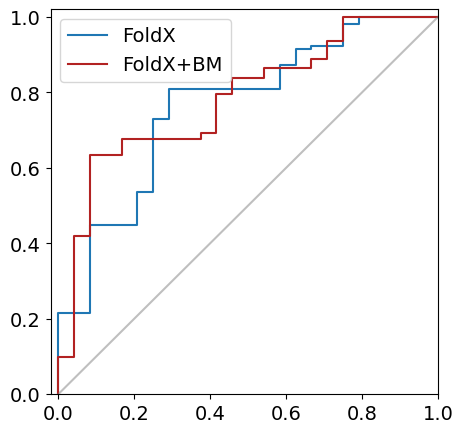

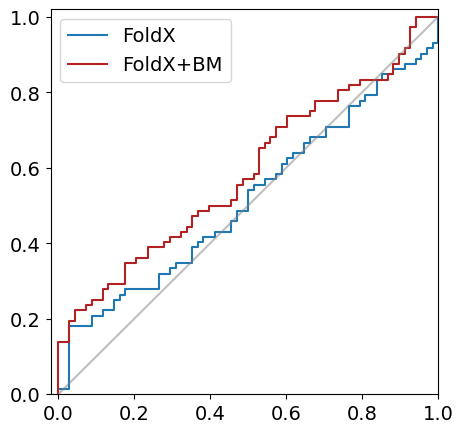

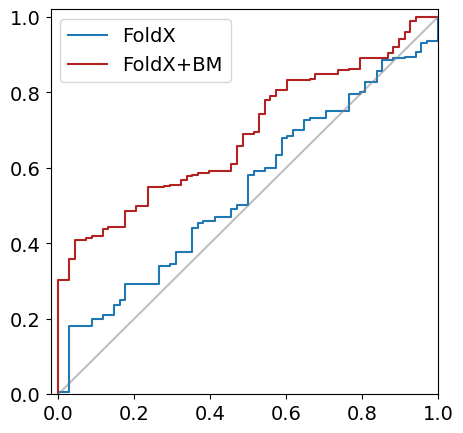

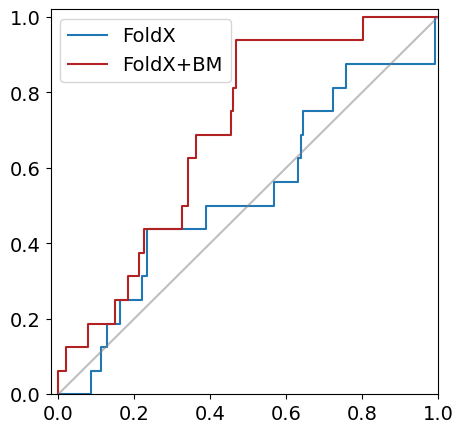

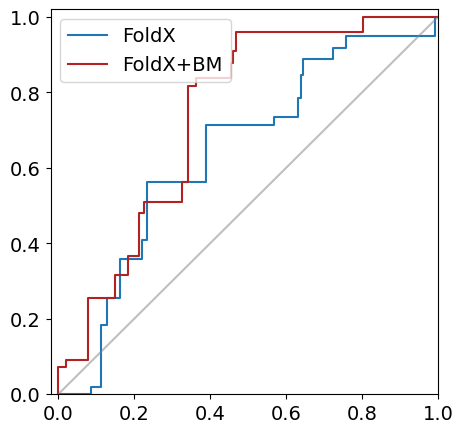

[0.55 0.52 0.53]
[0.69 0.59 0.69]


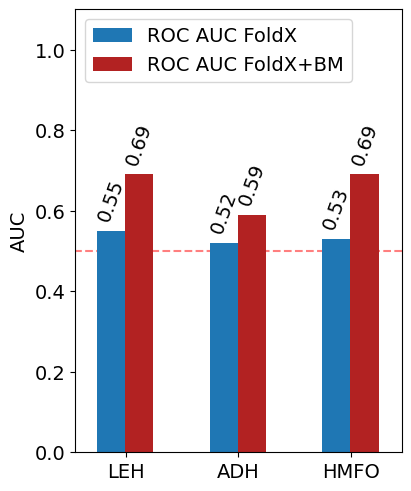

[0.76 0.54 0.64]
[0.78 0.69 0.74]


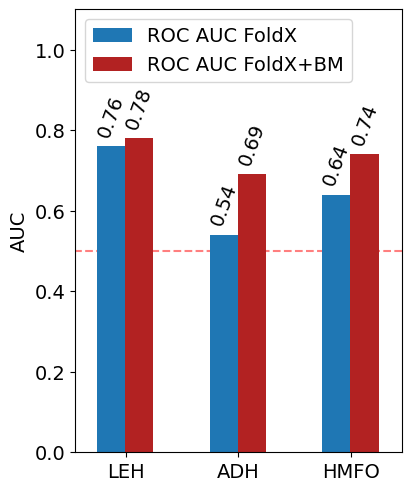

In [15]:
# figure 3: ROC curves and weighted ROC curves for FRESCO data

# make (W)ROC cuves and calculate (W)AUC
aucs_leh = plot_roc(leh_data, name_out='./figures/fig_3-ROC-leh.png')
waucs_leh = plot_roc(leh_data, scale=True, name_out='./figures/fig_3-WROC-leh.png')

aucs_adh = plot_roc(adh_data, name_out='./figures/fig_3-ROC-adh.png')
waucs_adh = plot_roc(adh_data, scale=True, name_out='./figures/fig_3-WROC-adh.png')

aucs_hmfo = plot_roc(hmfo_data, name_out='./figures/fig_3-ROC-hmfo.png')
waucs_hmfo = plot_roc(hmfo_data, scale=True, name_out='./figures/fig_3-WROC-hmfo.png')

# make barplot of (W)AUC values
species = ['LEH', 'ADH', 'HMFO']
values_auc = {
    'ROC AUC FoldX': np.round([aucs_leh[0], aucs_adh[0], aucs_hmfo[0]], 2),
    'ROC AUC FoldX+BM': np.round([aucs_leh[1], aucs_adh[1], aucs_hmfo[1]], 2)}
values_wauc = {
    'ROC AUC FoldX': np.round([waucs_leh[0], waucs_adh[0], waucs_hmfo[0]], 2),
    'ROC AUC FoldX+BM': np.round([waucs_leh[1], waucs_adh[1], waucs_hmfo[1]], 2)}
colors = {'ROC AUC FoldX':'tab:blue', 'ROC AUC FoldX+BM':'firebrick'}

plot_bars(values_auc, species, colors, headspace=0.1, name_out='./figures/fig_3-bars-AUC.png')
plot_bars(values_wauc, species, colors, headspace=0.1, name_out='./figures/fig_3-bars-WAUC.png')

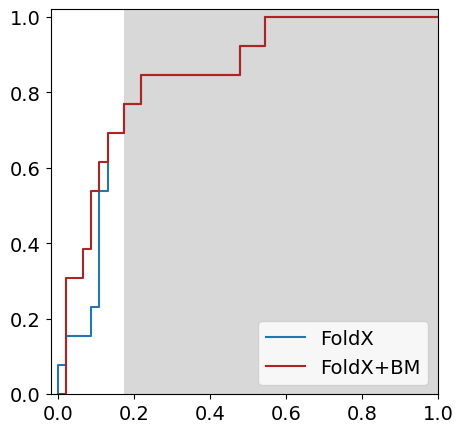

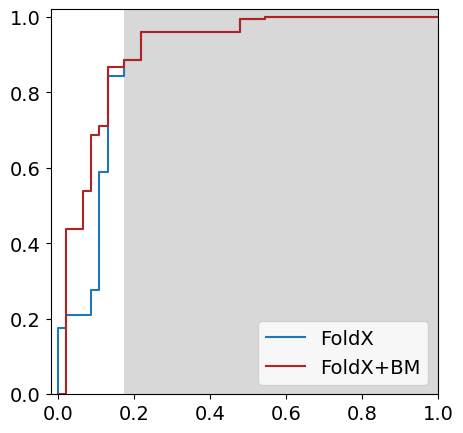

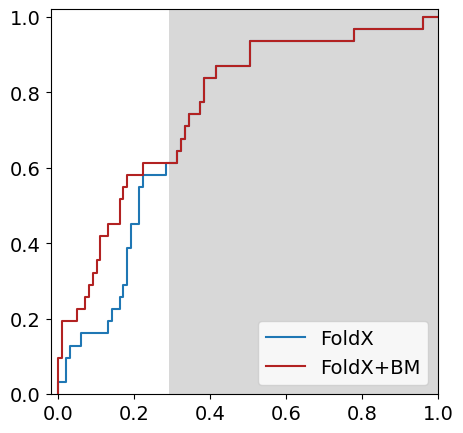

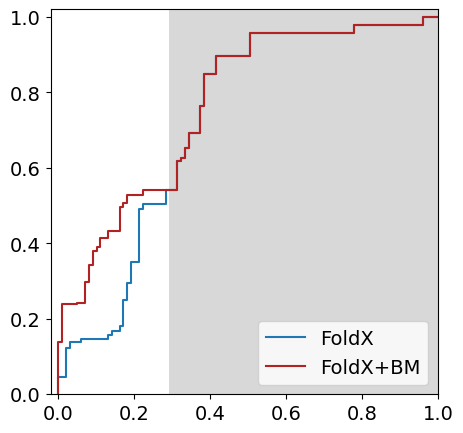

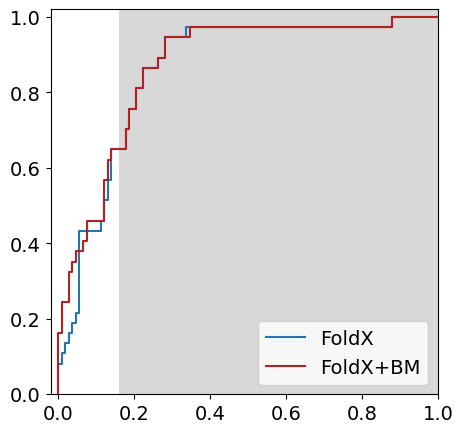

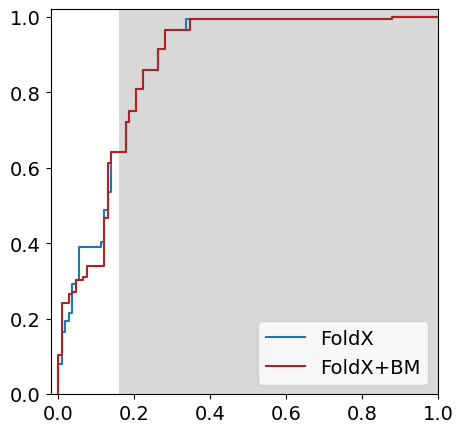

[0.83 0.86 0.73]
[0.85 0.87 0.76]


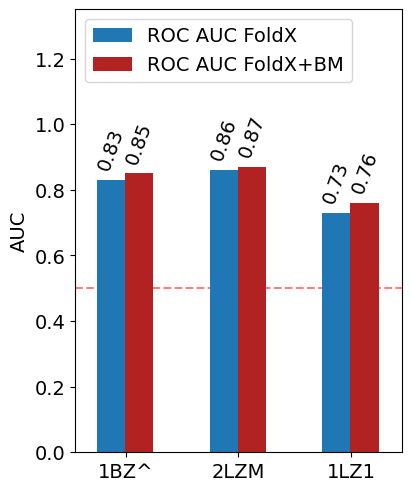

[0.88 0.87 0.72]
[0.91 0.87 0.77]


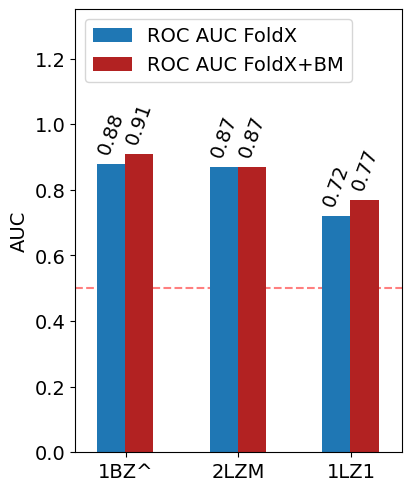

In [18]:
# figure 4: make (W)ROC cuves and calculate (W)AUC using FoldX as predictor
aucs_t1bz6 =  plot_roc_fullrange(t1bz6_data, name_out='./figures/fig_4-ROC-1bz6-foldx.png',
                                 predictor='foldx_raw', predictor_scaled='foldx', 
                                 exclude=['SO', 'SO_raw'])
waucs_t1bz6 = plot_roc_fullrange(t1bz6_data, name_out='./figures/fig_4-WROC-1bz6-foldx.png', scale=True,
                                 predictor='foldx_raw', predictor_scaled='foldx', 
                                 exclude=['SO', 'SO_raw'])
aucs_t1lz1 = plot_roc_fullrange(t1lz1_data, name_out='./figures/fig_4-ROC-1lz1-foldx.png',
                                 predictor='foldx_raw', predictor_scaled='foldx', 
                                 exclude=['SO', 'SO_raw'])
waucs_t1lz1 = plot_roc_fullrange(t1lz1_data, name_out='./figures/fig_4-WROC-1lz1-foldx.png', scale=True,
                                 predictor='foldx_raw', predictor_scaled='foldx', 
                                 exclude=['SO', 'SO_raw'])
aucs_2lzm = plot_roc_fullrange(t2lzm_data,name_out='./figures/fig_4-ROC-2lzm-foldx.png',
                                 predictor='foldx_raw', predictor_scaled='foldx', 
                                 exclude=['SO', 'SO_raw'])
waucs_2lzm = plot_roc_fullrange(t2lzm_data, name_out='./figures/fig_4-WROC-2lzm-foldx.png', scale=True,
                                 predictor='foldx_raw', predictor_scaled='foldx', 
                                 exclude=['SO', 'SO_raw'])


# make barplot of (W)AUC values using foldx as predictor
species = ['1BZ^', '2LZM', '1LZ1']
values_auc = {
    'ROC AUC FoldX': np.round([aucs_t1bz6[0], aucs_2lzm[0], aucs_t1lz1[0]], 2),
    'ROC AUC FoldX+BM': np.round([aucs_t1bz6[1], aucs_2lzm[1], aucs_t1lz1[1]], 2)}
values_wauc = {
    'ROC AUC FoldX': np.round([waucs_t1bz6[0], waucs_2lzm[0], waucs_t1lz1[0]], 2),
    'ROC AUC FoldX+BM': np.round([waucs_t1bz6[1], waucs_2lzm[1], waucs_t1lz1[1]], 2)}
colors = {'ROC AUC FoldX':'tab:blue', 'ROC AUC FoldX+BM':'firebrick'}

plot_bars(values_auc, species, colors, headspace=0.35, name_out='./figures/fig_4-bars-foldx-AUC.png')
plot_bars(values_wauc, species, colors, headspace=0.35, name_out='./figures/fig_4-bars-foldx-WAUC.png')

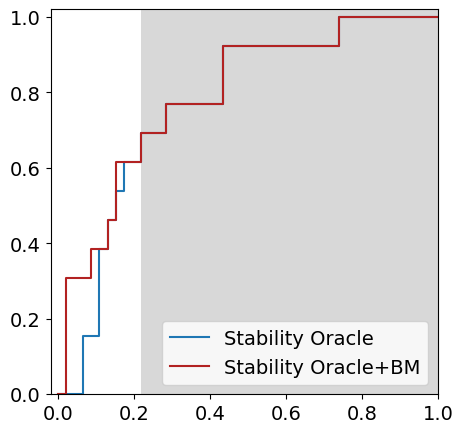

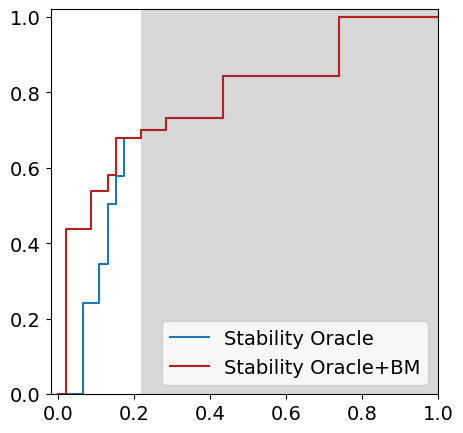

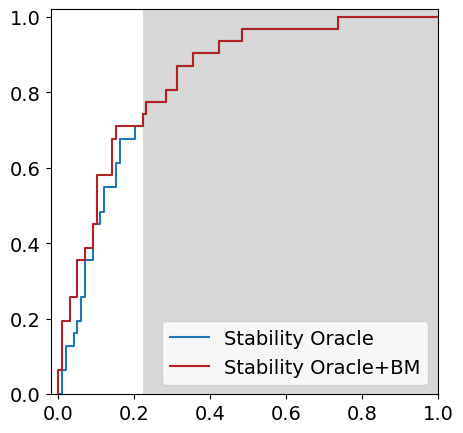

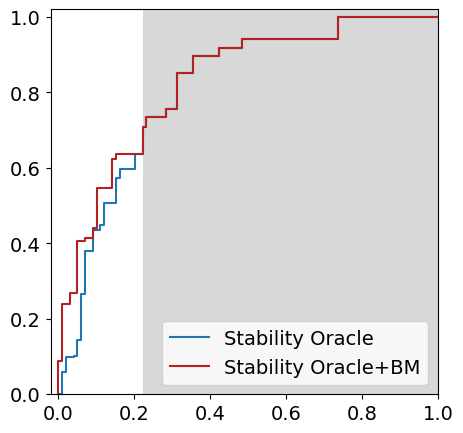

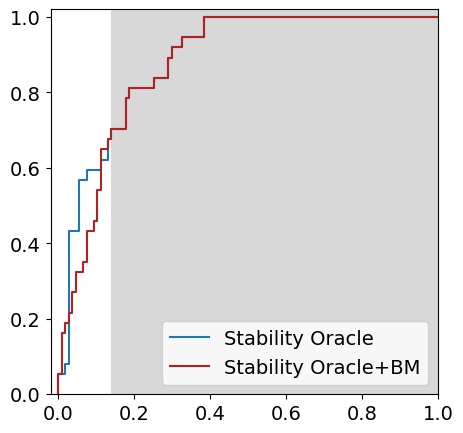

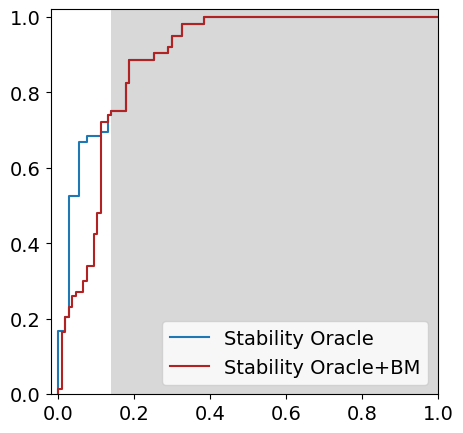

[0.77 0.89 0.83]
[0.79 0.88 0.84]


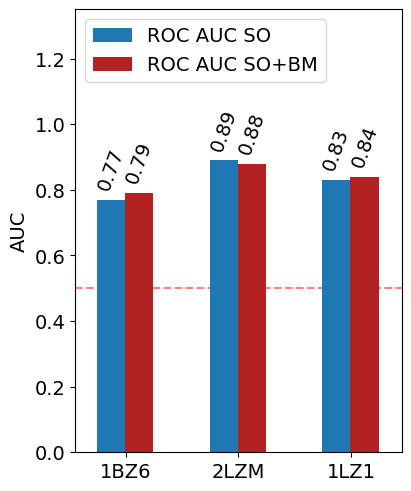

[0.75 0.91 0.81]
[0.78 0.89 0.83]


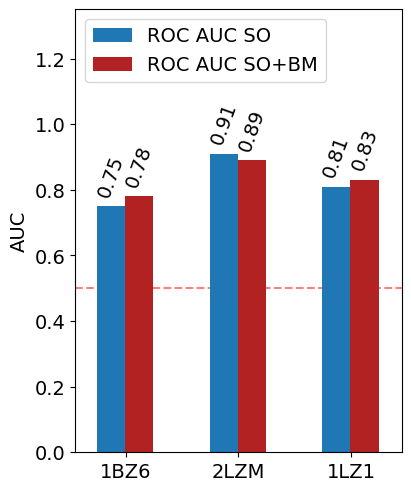

In [17]:
# figure 4: make (W)ROC cuves and calculate (W)AUC using Stability Oracle as predictor
aucs_t1bz6 =  plot_roc_fullrange(t1bz6_data, name_out='./figures/fig_4-ROC-1bz6-SO.png',
                                 predictor='SO_raw', predictor_scaled='SO', 
                                 exclude=['foldx', 'foldx_raw'])
waucs_t1bz6 = plot_roc_fullrange(t1bz6_data, name_out='./figures/fig_4-WROC-1bz6-SO.png', scale=True,
                                 predictor='SO_raw', predictor_scaled='SO', 
                                 exclude=['foldx', 'foldx_raw'])
aucs_t1lz1 = plot_roc_fullrange(t1lz1_data, name_out='./figures/fig_4-ROC-1lz1-SO.png',
                                 predictor='SO_raw', predictor_scaled='SO', 
                                 exclude=['foldx', 'foldx_raw'])
waucs_t1lz1 = plot_roc_fullrange(t1lz1_data, name_out='./figures/fig_4-WROC-1lz1-SO.png', scale=True,
                                 predictor='SO_raw', predictor_scaled='SO', 
                                 exclude=['foldx', 'foldx_raw'])
aucs_2lzm = plot_roc_fullrange(t2lzm_data,name_out='./figures/fig_4-ROC-2lzm-SO.png',
                                 predictor='SO_raw', predictor_scaled='SO', 
                                 exclude=['foldx', 'foldx_raw'])
waucs_2lzm = plot_roc_fullrange(t2lzm_data, name_out='./figures/fig_4-WROC-2lzm-SO.png', scale=True,
                                 predictor='SO_raw', predictor_scaled='SO', 
                                 exclude=['foldx', 'foldx_raw'])

# make barplot of (W)AUC values using Stability Oracle as predictor
species = ['1BZ6', '2LZM', '1LZ1']
values_auc = {
    'ROC AUC SO': np.round([aucs_t1bz6[0], aucs_2lzm[0], aucs_t1lz1[0]], 2),
    'ROC AUC SO+BM': np.round([aucs_t1bz6[1], aucs_2lzm[1], aucs_t1lz1[1]], 2)}
values_wauc = {
    'ROC AUC SO': np.round([waucs_t1bz6[0], waucs_2lzm[0], waucs_t1lz1[0]], 2),
    'ROC AUC SO+BM': np.round([waucs_t1bz6[1], waucs_2lzm[1], waucs_t1lz1[1]], 2)}
colors = {'ROC AUC SO':'tab:blue', 'ROC AUC SO+BM':'firebrick'}

plot_bars(values_auc, species, colors, headspace=0.35, name_out='./figures/fig_4-bars-SO-AUC.png')
plot_bars(values_wauc, species, colors, headspace=0.35, name_out='./figures/fig_4-bars-SO-WAUC.png')

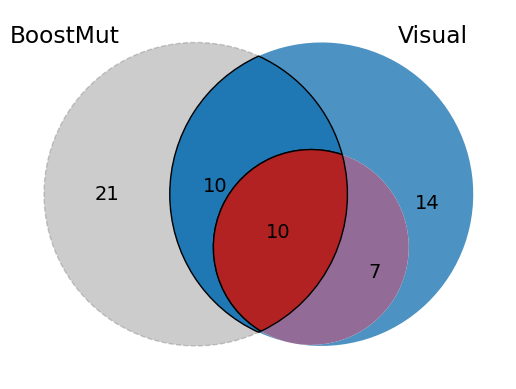

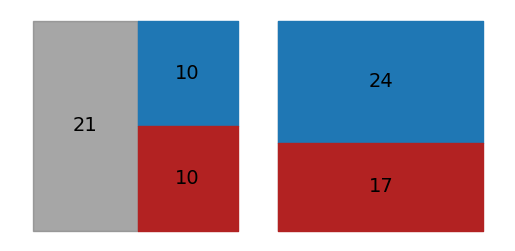

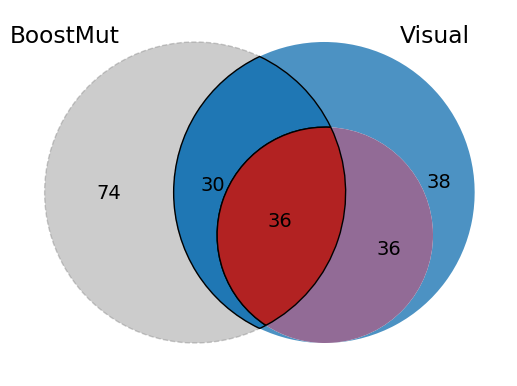

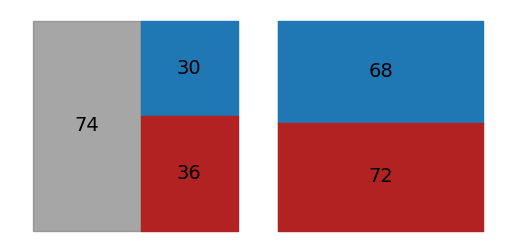

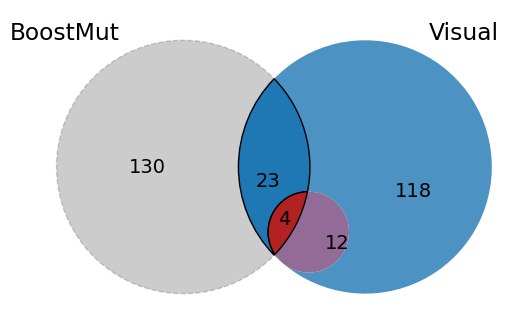

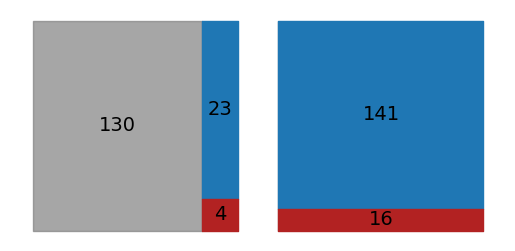

In [31]:
# figure 5: Venn diagrams for BoostMut vs visual inspection

plot_venn(leh_data, name_out='./figures/fig_5-leh-venn.png')
plot_square(leh_data, name_out='./figures/fig_5-leh-square.png')

plot_venn(adh_data, name_out='./figures/fig_5-adh-venn.png')
plot_square(adh_data, name_out='./figures/fig_5-adh-square.png')

plot_venn(hmfo_data, name_out='./figures/fig_5-hmfo-venn.png')
plot_square(hmfo_data, name_out='./figures/fig_5-hmfo-square.png')

In [ ]:
# figure 6

In [ ]:
# figure 7

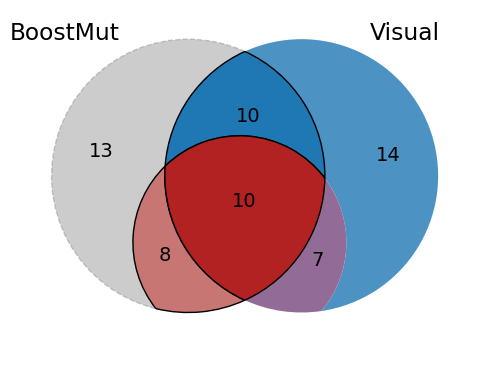

In [57]:
def plot_venn(data, name_out='out-venn.png', add_stab=[]):
    boostmut_cols = [i for i in data.columns if i not in ['exp_tested', 'stabilizing', 'dtm']]
    sel_exp =  data[data.exp_tested].index
    sel_boostmut = data[boostmut_cols].sum(axis=1).sort_values(ascending=False).index[:len(sel_exp)]
    sel_stab = list(data[data.stabilizing].index)+add_stab
    
    v = venn3([set(sel_boostmut), set(sel_exp), set(sel_stab)], ['BoostMut', 'Visual', ''],
         set_colors=("grey", "tab:blue", "firebrick"))
    v.get_patch_by_id('100').set_color('grey')
    v.get_patch_by_id('010').set_alpha(0.8)
    v.get_patch_by_id('011').set_alpha(1)
    v.get_patch_by_id('100').set_linestyle('dashed')
    v.get_patch_by_id('110').set_alpha(1)
    v.get_patch_by_id('110').set_color('tab:blue')
    v.get_patch_by_id('110').set_ec('black')
    v.get_patch_by_id('110').set_lw(1)
    v.get_patch_by_id('111').set_alpha(1)
    v.get_patch_by_id('111').set_color('firebrick')
    v.get_patch_by_id('111').set_ec('black')
    v.get_patch_by_id('111').set_lw(1)
    #new
    v.get_patch_by_id('001').set_color('white')
    v.get_label_by_id('001').set_text('')
    v.get_patch_by_id('101').set_ec('black')
    v.get_patch_by_id('101').set_alpha(1)
    v.get_patch_by_id('101').set_color('#C87673')
    v.get_patch_by_id('101').set_lw(1)
    v.get_patch_by_id('101').set_ec('black')
    #v.get_patch_by_id('100').set_color('dashed')
    plt.savefig(name_out, bbox_inches='tight', dpi=300)
    plt.show()
leh_notstab_new = ['G18Q', 'A11R', 'T85M', 'R9P', 'E6R', 'L29I', 'E6P', 'A48H','E30K','L94Y','L94H']
leh_stab_new = ['Q7R', 'S21R', 'Q7P', 'G18S', 'D24K', 'G18K', 'L106I', 'G18R']
plot_venn(leh_data, name_out='./figures/fig_5-leh-venn-newmuts.png', add_stab=leh_stab_new)


In [54]:
len(leh_notstab_new)+len(leh_stab_new)

19

In [ ]:
import pandas as pd
import sklearn

data = pd.read_csv('input_data.csv', index_col=0)
features = data['e_hbonds_r', 'score_sc_r', 'rmsf_bb_r']
labels = data['stabilizing']

# split data
feat_train, feat_test, lab_train, lab_test = sklearn.model_selection.train_test_split(features, labels, 
                                                                                        test_size=0.3, random_state=42)

# train model
randomforest = sklearn.ensemble.RandomForestClassifier(random_state=42)
randomforest.fit(feat_train, lab_train)

# use model to predict labels for train/test data
pred_train =  randomforests.predict(feat_train, lab_train)
pred_test = randomforests.predict(feat_test, lab_test)

# calculate statistics comparing real labels vs predicted labels for test data
print(sklearn.metrics.accuracy_score(lab_test, pred_test))
print(sklearn.metrics.precision_score(lab_test, pred_test))
print(sklearn.metrics.roc_auc_score(lab_test, pred_test))

# calculate statistics comparing real labels vs predicted labels for training data
print(sklearn.metrics.accuracy_score(lab_train, pred_train))
print(sklearn.metrics.precision_score(lab_train, pred_train))
print(sklearn.metrics.roc_auc_score(lab_train, pred_train))

TypeError: missing a required argument: 'y_true'

In [28]:
len(leh_data)+len(adh_data)+len(hmfo_data)+len(t1bz6_data)+len(t2lzm_data)+len(t1lz1_data)

1584

333

In [29]:
leh_data

,e_hbonds_r,hbonds_unsat_r,score_sc_r,hpsasa_r,rmsf_bb_r,e_hbonds_s,hbonds_unsat_s,score_sc_s,hpsasa_s,rmsf_bb_s,foldx,saltb_p,exp_tested,stabilizing,dtm
S12R,1.450212,-1.238630,1.016904,0.961133,1.431014,2.553873,-0.115627,1.484049,2.374029,1.004611,-0.047677,1.974341,True,True,0.3
K13P,-0.053093,-0.146680,1.019539,0.204827,-0.535180,0.696272,0.122429,2.966670,0.924977,0.710617,0.238244,1.923717,True,False,-4.0
A16R,2.560211,-2.265390,0.214977,0.840829,0.110744,2.033261,0.122429,-0.916881,1.378689,-1.319511,0.577536,1.508599,True,False,-0.5
S111R,0.470294,-1.075653,-0.843807,0.961133,1.624494,1.870253,0.510121,0.682696,1.740568,1.268567,1.667284,1.690846,True,False,0.0
D33K,0.240409,-0.953419,-0.357491,0.797928,-0.005459,1.135213,0.421700,0.324764,0.515962,1.211881,1.387482,1.569348,True,False,-1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E124R,0.068769,-2.428367,-1.773566,-0.172374,0.303367,-0.081940,-1.992873,-1.205494,-0.041746,-1.024975,0.190567,1.538974,True,False,-2.8
A48L,0.320448,0.154829,-0.861154,-0.347449,-1.412404,0.692546,-0.904615,-2.209296,0.471343,-1.517685,0.976603,0.860610,False,False,NaN
E49R,-1.246194,-1.866094,-2.455023,0.440379,-0.393840,0.390006,-0.918218,-1.991884,1.149985,-0.996103,-0.899181,-1.579473,False,False,NaN
E138R,-1.145551,-2.852109,0.150633,0.677193,0.658531,-0.907856,-2.571010,-0.829689,0.426879,0.547765,-1.446972,-0.951734,False,False,NaN
